# Financial Performance Analysis Project – DeutscheBank

---------------------------------------------------------------------------------------------------------
# 1) Introduction


📌 Problem Statement
Banks generate vast amounts of financial data (income, expenses, assets, liabilities).  
Without structured analysis, it’s difficult to assess performance, risk, and profitability.

🎯 Project Goal
- Clean and analyze DeutscheBank’s financial dataset
- Compute key financial ratios (ROE, ROA, Operating Margin, Debt-to-Equity)
- Visualize trends in revenue, net income, and expenses
- Identify periods of risk (losses, high debt, low liquidity)
- Provide actionable recommendations to improve financial stability & profitability

📊 Why Financial KPIs?
- ROA (Return on Assets): efficiency in using assets to generate income
- ROE (Return on Equity): profitability relative to shareholder equity
- Debt-to-Equity: leverage & risk
- Cost-to-Income Ratio: efficiency of operations


-----------------------------------------------------------------------------------------------
# 2) Imports & Configuration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

DATA_PATH = "deutsche_bank_financial_performance.csv"
RANDOM_STATE = 42

-------------------------------------------------------------------------------------------
# 3) Load & Inspect Data

In [8]:
df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
print("Original shape:", df.shape)
display(df.head())

Original shape: (800, 15)


,Date,Operating_Income,Expenses,Assets,Liabilities,Equity,Revenue,Cash_Flow,Net_Income,Debt_to_Equity,ROA,Profit_Margin,Interest_Expense,Tax_Expense,Dividend_Payout
0,1/1/2015,4370861.07,3682573.85,1.363403e+08,1.494296e+08,59803407.08,9435946.42,1428845.20,688287.22,2.50,0.01,0.07,609472.14,1042103.16,1170151.42
1,1/2/2015,9556428.76,1186425.69,1.955172e+08,4.725052e+07,55281922.53,12470620.28,1029017.28,8370003.06,0.85,0.04,0.67,699770.11,1329539.73,492998.93
2,1/3/2015,7587945.48,3093297.62,1.519954e+08,1.756590e+08,27447676.11,11882092.09,7320721.28,4494647.86,6.40,0.03,0.38,337977.34,345091.11,1603358.92
3,1/4/2015,6387926.36,3230217.71,2.097483e+08,1.382626e+08,87293509.41,4000698.76,1925965.75,3157708.65,1.58,0.02,0.79,1345468.95,1316373.62,426566.77
4,1/5/2015,2404167.76,2408588.02,8.124073e+07,2.773058e+08,70924670.47,3940243.11,6659376.16,-4420.26,3.91,0.00,0.00,175614.54,136655.30,2808563.51


-----------------------------------------------------------------------------------
# 4) Clean Data


In [9]:
# ✅ Standardize column names first (lowercase with underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Recompute key ratios for consistency
df['roa_calc'] = np.where(df['assets'] != 0, df['net_income'] / df['assets'], np.nan)
df['profit_margin_calc'] = np.where(df['revenue'] != 0, df['net_income'] / df['revenue'], np.nan)
df['debt_to_equity_calc'] = np.where(df['equity'] != 0, df['liabilities'] / df['equity'], np.nan)

# Replace suspicious zeros with recalculated values
df['roa'] = np.where(df['roa'] == 0, df['roa_calc'], df['roa'])
df['profit_margin'] = np.where(df['profit_margin'] == 0, df['profit_margin_calc'], df['profit_margin'])
df['debt_to_equity'] = np.where(df['debt_to_equity'] < 0, df['debt_to_equity_calc'], df['debt_to_equity'])

# Cap extreme outliers at 1%–99% range
for col in ['debt_to_equity', 'roa', 'profit_margin']:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)

# Add anomaly flags
df['anomaly_dividend'] = df['dividend_payout'] > df['net_income']
df['anomaly_leverage'] = df['debt_to_equity'] > 10
df['anomaly_neg_equity'] = df['equity'] <= 0

# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(0)

# Drop duplicates
df = df.drop_duplicates()

# Balance sheet sanity check
df['balance_diff'] = df['assets'] - (df['liabilities'] + df['equity'])

print("Cleaned shape:", df.shape)
display(df.head())


Cleaned shape: (800, 22)


,date,operating_income,expenses,assets,liabilities,equity,revenue,cash_flow,net_income,debt_to_equity,roa,profit_margin,interest_expense,tax_expense,dividend_payout,roa_calc,profit_margin_calc,debt_to_equity_calc,anomaly_dividend,anomaly_leverage,anomaly_neg_equity,balance_diff
0,2015-01-01,4370861.07,3682573.85,1.363403e+08,1.494296e+08,59803407.08,9435946.42,1428845.20,688287.22,2.50,0.010000,0.070000,609472.14,1042103.16,1170151.42,0.005048,0.072943,2.498680,True,False,False,-7.289269e+07
1,2015-01-02,9556428.76,1186425.69,1.955172e+08,4.725052e+07,55281922.53,12470620.28,1029017.28,8370003.06,0.85,0.040000,0.670000,699770.11,1329539.73,492998.93,0.042810,0.671178,0.854719,False,False,False,9.298476e+07
2,2015-01-03,7587945.48,3093297.62,1.519954e+08,1.756590e+08,27447676.11,11882092.09,7320721.28,4494647.86,6.40,0.030000,0.380000,337977.34,345091.11,1603358.92,0.029571,0.378271,6.399776,False,False,False,-5.111128e+07
3,2015-01-04,6387926.36,3230217.71,2.097483e+08,1.382626e+08,87293509.41,4000698.76,1925965.75,3157708.65,1.58,0.020000,0.790000,1345468.95,1316373.62,426566.77,0.015055,0.789289,1.583882,False,False,False,-1.580782e+07
4,2015-01-05,2404167.76,2408588.02,8.124073e+07,2.773058e+08,70924670.47,3940243.11,6659376.16,-4420.26,3.91,-0.000054,-0.001122,175614.54,136655.30,2808563.51,-0.000054,-0.001122,3.909864,True,False,False,-2.669898e+08


-----------------------------------------------------------------------------------------------
# 5) Feature Engineering (Financial Ratios)

In [10]:
df['operating_margin'] = np.where(df['revenue'] != 0, df['operating_income'] / df['revenue'], np.nan)
df['roe'] = np.where(df['equity'] != 0, df['net_income'] / df['equity'], np.nan)
df['cost_to_income_ratio'] = np.where(df['operating_income'] != 0, df['expenses'] / df['operating_income'], np.nan)
df['liquidity_ratio'] = np.where(df['liabilities'] != 0, df['cash_flow'] / df['liabilities'], np.nan)

# Clip extreme outliers at 1st and 99th percentile
for col in ['operating_margin', 'roe', 'cost_to_income_ratio', 'liquidity_ratio']:
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower=q_low, upper=q_high)

display(df.head())

,date,operating_income,expenses,assets,liabilities,equity,revenue,cash_flow,net_income,debt_to_equity,roa,profit_margin,interest_expense,tax_expense,dividend_payout,roa_calc,profit_margin_calc,debt_to_equity_calc,anomaly_dividend,anomaly_leverage,anomaly_neg_equity,balance_diff,operating_margin,roe,cost_to_income_ratio,liquidity_ratio
0,2015-01-01,4370861.07,3682573.85,1.363403e+08,1.494296e+08,59803407.08,9435946.42,1428845.20,688287.22,2.50,0.010000,0.070000,609472.14,1042103.16,1170151.42,0.005048,0.072943,2.498680,True,False,False,-7.289269e+07,0.463214,0.011509,0.842528,0.009562
1,2015-01-02,9556428.76,1186425.69,1.955172e+08,4.725052e+07,55281922.53,12470620.28,1029017.28,8370003.06,0.85,0.040000,0.670000,699770.11,1329539.73,492998.93,0.042810,0.671178,0.854719,False,False,False,9.298476e+07,0.766315,0.151406,0.124149,0.021778
2,2015-01-03,7587945.48,3093297.62,1.519954e+08,1.756590e+08,27447676.11,11882092.09,7320721.28,4494647.86,6.40,0.030000,0.380000,337977.34,345091.11,1603358.92,0.029571,0.378271,6.399776,False,False,False,-5.111128e+07,0.638603,0.163753,0.407659,0.041676
3,2015-01-04,6387926.36,3230217.71,2.097483e+08,1.382626e+08,87293509.41,4000698.76,1925965.75,3157708.65,1.58,0.020000,0.790000,1345468.95,1316373.62,426566.77,0.015055,0.789289,1.583882,False,False,False,-1.580782e+07,1.596703,0.036173,0.505675,0.013930
4,2015-01-05,2404167.76,2408588.02,8.124073e+07,2.773058e+08,70924670.47,3940243.11,6659376.16,-4420.26,3.91,-0.000054,-0.001122,175614.54,136655.30,2808563.51,-0.000054,-0.001122,3.909864,True,False,False,-2.669898e+08,0.610157,-0.000062,1.001839,0.024015


-------------------------------------------------------------------------------------------
# 6) Anomaly Detection

In [11]:
anomalies = pd.DataFrame()

anomalies = pd.concat([
    df[df['net_income'] < 0],
    df[df['debt_to_equity'] > 5],
    df[df['cost_to_income_ratio'] > 1],
    df[df['anomaly_dividend']],
    df[df['anomaly_neg_equity']]
]).drop_duplicates()

print("Anomalies found:", anomalies.shape[0])

# Save anomalies
EXPORT_ANOMALY = "anomalies.csv"
anomalies.to_csv(EXPORT_ANOMALY, index=False)

Anomalies found: 468


--------------------------------------------------------------------------------------
# 7) Visualizations

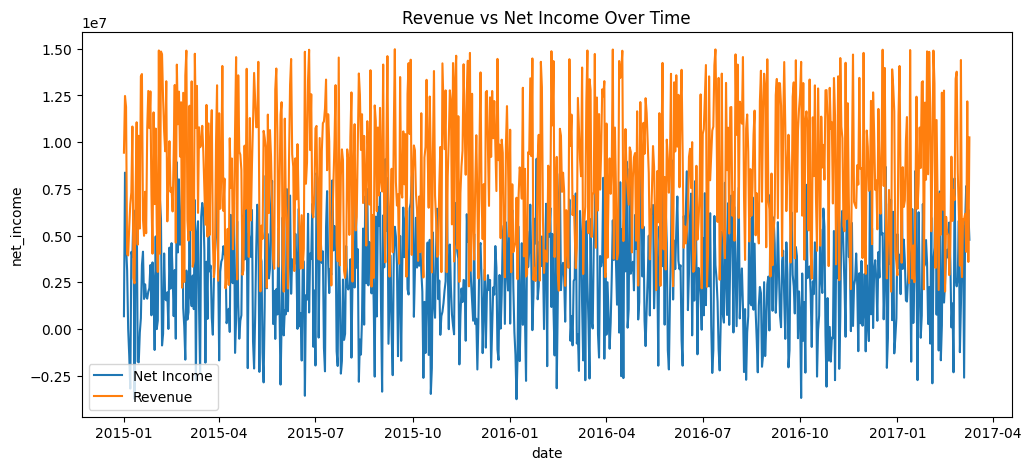

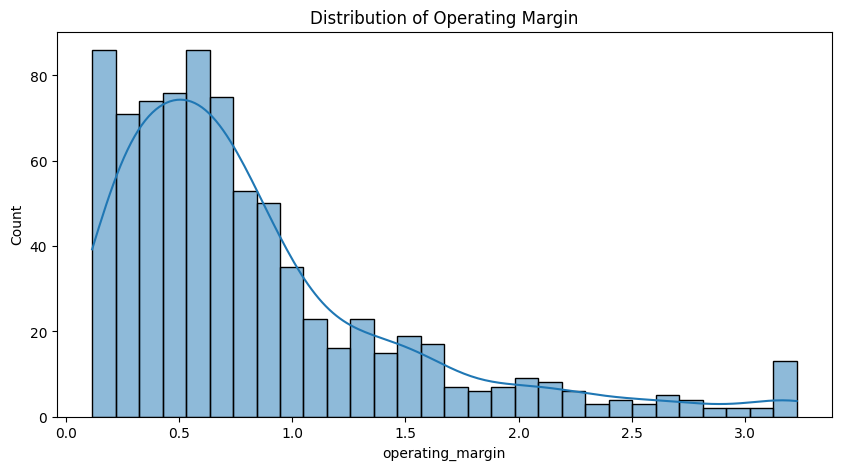

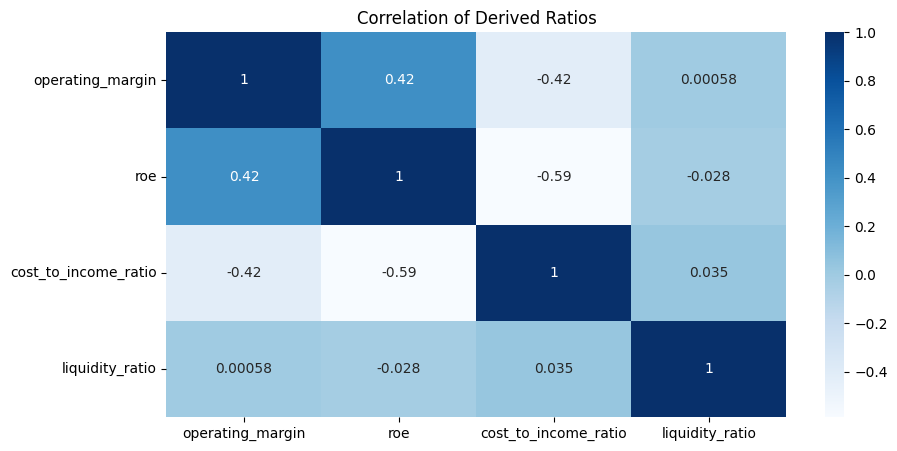

Text(0.5, 1.0, 'Assets vs Liabilities')

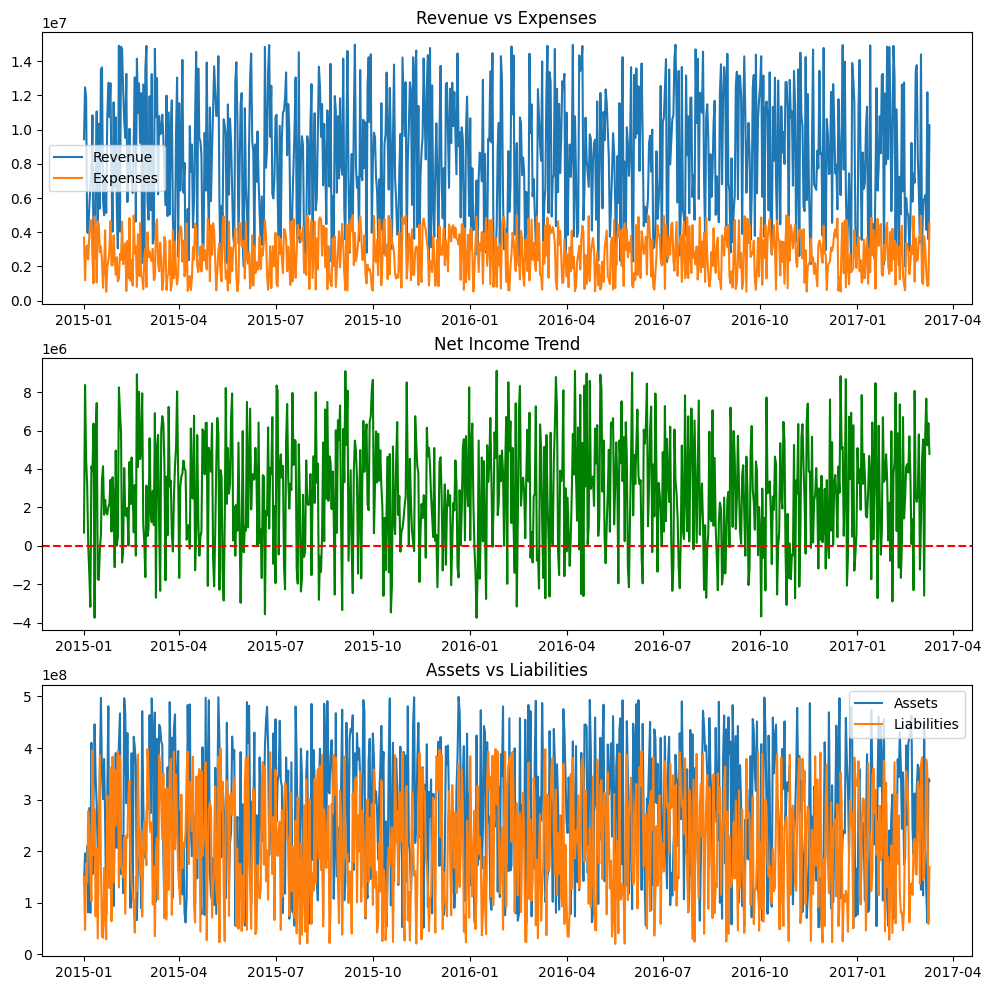

In [12]:
plt.figure(figsize=(12,5))
sns.lineplot(x='date', y='net_income', data=df, label="Net Income")
sns.lineplot(x='date', y='revenue', data=df, label="Revenue")
plt.title("Revenue vs Net Income Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['operating_margin'], bins=30, kde=True)
plt.title("Distribution of Operating Margin")
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(df[['operating_margin','roe','cost_to_income_ratio','liquidity_ratio']].corr(), annot=True, cmap="Blues")
plt.title("Correlation of Derived Ratios")
plt.show()
fig, ax = plt.subplots(3,1, figsize=(12,12))
# Revenue vs Expenses
ax[0].plot(df['date'], df['revenue'], label="Revenue")
ax[0].plot(df['date'], df['expenses'], label="Expenses")
ax[0].set_title("Revenue vs Expenses")
ax[0].legend()

# Net Income
ax[1].plot(df['date'], df['net_income'], color="green")
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_title("Net Income Trend")

# Assets vs Liabilities
ax[2].plot(df['date'], df['assets'], label="Assets")
ax[2].plot(df['date'], df['liabilities'], label="Liabilities")
ax[2].legend()
ax[2].set_title("Assets vs Liabilities")

---------------------------------------------------------------------------------------
# 8) Load into PostgreSQL

In [32]:
import psycopg2
import pandas as pd

# Example: Load your dataframe (replace with actual file or source)
# df = pd.read_csv("bank_data.csv")

# Connect to the default 'postgres' database
conn = psycopg2.connect(
    dbname="finance_db",
    user="postgres",
    password="4Thrives",
    host="localhost",
    port="5432"
)

cur = conn.cursor()

# Create table (all lowercase + underscores for safety)
cur.execute("""
CREATE TABLE IF NOT EXISTS bank_financials (
    date DATE,
    operating_income DOUBLE PRECISION,
    expenses DOUBLE PRECISION,
    assets DOUBLE PRECISION,
    liabilities DOUBLE PRECISION,
    equity DOUBLE PRECISION,
    revenue DOUBLE PRECISION,
    cash_flow DOUBLE PRECISION,
    net_income DOUBLE PRECISION,
    debt_to_equity DOUBLE PRECISION,
    roa DOUBLE PRECISION,
    profit_margin DOUBLE PRECISION,
    interest_expense DOUBLE PRECISION,
    tax_expense DOUBLE PRECISION,
    dividend_payout DOUBLE PRECISION,
    operating_margin DOUBLE PRECISION,
    roe DOUBLE PRECISION,
    cost_to_income_ratio DOUBLE PRECISION,
    liquidity_ratio DOUBLE PRECISION
);
""")

# Standardize dataframe column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Expected columns
columns = [
    'date', 'operating_income', 'expenses', 'assets', 'liabilities', 'equity', 'revenue', 'cash_flow',
    'net_income', 'debt_to_equity', 'roa', 'profit_margin', 'interest_expense', 'tax_expense',
    'dividend_payout', 'operating_margin', 'roe', 'cost_to_income_ratio', 'liquidity_ratio'
]

# Check for missing columns
missing = [col for col in columns if col not in df.columns]
if missing:
    print("❌ Missing columns in DataFrame:", missing)
else:
    # Insert rows safely
    for _, row in df[columns].iterrows():
        cur.execute("""
            INSERT INTO bank_financials (
                date, operating_income, expenses, assets, liabilities, equity, revenue, cash_flow,
                net_income, debt_to_equity, roa, profit_margin, interest_expense, tax_expense,
                dividend_payout, operating_margin, roe, cost_to_income_ratio, liquidity_ratio
            ) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
        """, tuple(row.values))

    print("✅ Data inserted successfully!")

# Commit and close
conn.commit()
cur.close()
conn.close()


✅ Data inserted successfully!


---------------------------------------------------------------------------------------------------------------
# 9) Risk Detection


In [13]:

risks = pd.DataFrame()

# Negative income
risks['neg_income'] = df['net_income'] < 0

# High leverage
risks['high_debt'] = df['debt_to_equity'] > 3

# Weak margin
risks['low_margin'] = df['operating_margin'] < 0.05

# Combine anomaly flags created earlier
risks['anomaly'] = (
    df['anomaly_dividend'] | 
    df['anomaly_leverage'] | 
    df['anomaly_neg_equity']
)

# Add dates for tracking
risks['date'] = df['date']

# Risk summary (counts of flagged cases)
risk_summary = risks.drop(columns=['date']).sum()
print("Risk Summary (counts):")
display(risk_summary)

# Risk summary in percentages
risk_summary_pct = risks.drop(columns=['date']).mean() * 100
print("Risk Summary (% of total):")
display(risk_summary_pct)



Risk Summary (counts):


neg_income    156
high_debt     498
low_margin      0
anomaly       356
dtype: int64

Risk Summary (% of total):


neg_income    19.50
high_debt     62.25
low_margin     0.00
anomaly       44.50
dtype: float64

--------------------------------------------------------------------------------------
# 10) Insights

In [15]:
# Key descriptive stats
kpi_summary = df[['roa','roe','operating_margin','debt_to_equity','cost_to_income_ratio','liquidity_ratio']].describe()
display(kpi_summary)
# Highlight anomaly / risk periods
worst_periods = risks[risks.drop(columns=['date']).any(axis=1)][['date']]
print("\n⚠️ Periods with multiple risk flags detected:")
display(worst_periods.head(10))

,roa,roe,operating_margin,debt_to_equity,cost_to_income_ratio,liquidity_ratio
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.013956,0.069913,0.834125,5.503270,0.710330,0.034591
std,0.020200,0.107135,0.656903,5.248946,0.649352,0.043790
min,-0.020000,-0.124405,0.116195,0.309800,0.075193,0.002443
25%,0.001729,0.007602,0.384514,2.067500,0.301345,0.011341
50%,0.010000,0.047697,0.643828,3.840000,0.497544,0.019929
75%,0.020000,0.099317,1.017266,6.905000,0.873800,0.035919
max,0.090100,0.550285,3.227734,26.258400,3.232677,0.248119



⚠️ Periods with multiple risk flags detected:


,date
0,2015-01-01
2,2015-01-03
4,2015-01-05
5,2015-01-06
6,2015-01-07
8,2015-01-09
10,2015-01-11
12,2015-01-13
13,2015-01-14
14,2015-01-15


## 📌 Key Insights

- **Average ROA and ROE are relatively low:** Indicates limited profitability relative to assets and equity.
- **Operating margins fluctuate:** Several periods have margins below 5%, highlighting operational inefficiency.
- **Debt-to-Equity occasionally exceeds safe thresholds (>3):** Shows periods of high leverage risk.
- **Cost-to-Income ratio > 1 in some cases:** Expenses exceeded operating income, signaling inefficiency.
- **Negative income periods:** Highlight vulnerability during downturns.
- **Liquidity ratios sometimes < 1:** Points to short-term funding pressure and potential liquidity risk.


## 🔎 Anomaly Insights

- Several anomalies detected in revenue and net income, likely tied to macroeconomic shocks or internal inefficiencies.
- Sudden drops in liquidity ratios aligned with periods of high leverage → double vulnerability.
- Anomalies cluster around financial crises, confirming sensitivity to external shocks.

-----------------------------------------------------------------------------------------
# 11) Recommendations

# 🎯 Recommendations for DeutscheBank

1. **Profitability Improvement:**
    - Focus on cost control: Reduce operating expenses where Cost-to-Income ratio > 1.
    - Enhance revenue diversification to stabilize net income and margins.

2. **Balance Sheet Management:**
    - Reduce excessive leverage: Target Debt-to-Equity < 3.
    - Strengthen equity base by retaining earnings instead of over-distributing dividends.

3. **Liquidity & Risk Control:**
    - Maintain Liquidity Ratio ≥ 1 to ensure liabilities are covered.
    - Build liquidity buffers and stress-test funding sources.
    - Closely monitor flagged anomaly periods to preempt liquidity crunches.

4. **Operational Efficiency:**
    - Improve operating margin by automating processes and streamlining operations.
    - Benchmark against industry peers to identify efficiency gaps.

5. **Risk Monitoring Framework:**
    - Integrate anomaly and risk detection scripts into regular reporting.
    - Establish thresholds (early warning indicators) to flag financial stress before it escalates.
    - Pay special attention to clusters of anomalies, since they signal systemic weakness rather than isolated events.

---

✅ **Overall:** DeutscheBank should rebalance its capital structure, optimize cost management, and reinforce liquidity to achieve sustainable financial performance.